In [16]:
from pathlib import Path
Path.cwd()

PosixPath('/mnt/e/collegeitem/third1/machinelearning/Fuxi-alpha-in-ReChorus')

In [24]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

LOG_DIR = "logs_saved"  # 你的 txt 都在这个相对目录下

# 只保留你关心的两个指标
METRICS_ORDER = ["HR@10", "NDCG@10"]

# 确保 figure 目录存在
os.makedirs("figure", exist_ok=True)


def parse_metrics_from_line(line: str):
    """
    从一行类似
    'Test After Training: (HR@5:0.3589,NDCG@5:0.2575,...)'
    中解析出一个 {metric_name: value} 的字典。
    """
    if "Test After Training" not in line:
        return None
    # 调试：看一下原始行
    # print("[DEBUG] parse line:", line.strip())

    m = re.search(r"Test After Training:\s*\((.*)\)", line)
    if not m:
        return None
    inside = m.group(1)
    parts = inside.split(",")
    metrics = {}
    for p in parts:
        if ":" not in p:
            continue
        k, v = p.split(":", 1)
        k = k.strip()
        v = v.strip()
        try:
            metrics[k] = float(v)
        except ValueError:
            pass
    return metrics if metrics else None


def parse_metrics_from_file(filepath: str):
    """
    打开一个 txt 文件，找到最后一行包含 'Test After Training' 的内容，
    并解析其中的 HR@10 / NDCG@10。
    """
    print(f"[INFO] 读取文件: {filepath}")

    if not os.path.exists(filepath):
        print(f"[WARN] 文件不存在: {filepath}")
        return None

    last_metrics = None
    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = parse_metrics_from_line(line)
            if m is not None:
                last_metrics = m

    if last_metrics is None:
        print(f"[WARN] 文件中没有找到 'Test After Training': {filepath}")
    else:
        print(f"[INFO] 解析到指标: {last_metrics}")
    return last_metrics


def build_filename(model: str, dataset_tag: str, depth: int, eval_type: str):
    """
    根据你给的命名规则拼出文件名（不含 logs_saved/）

    model: "fuxi" / "SASRec" / "TiSASRec"
    dataset_tag: "grocery" 或 "movielens_1M"
    depth: 整数深度
    eval_type: "test" 或 "test_all"
    """
    if model.lower() == "fuxi":
        if dataset_tag == "grocery":
            # fuxi_grocery_{depth}_test(.txt)
            fname = f"fuxi_grocery_{depth}_{eval_type}.txt"
        elif dataset_tag == "movielens_1M":
            # fuxi_movielens_1M_depth_{depth}_test(.txt)
            fname = f"fuxi_movielens_1M_depth_{depth}_{eval_type}.txt"
        else:
            raise ValueError(f"未知 dataset_tag: {dataset_tag}")
    else:
        # SASRec / TiSASRec
        # {Model}_{dataset_tag}_layers_{depth}_{eval_type}.txt
        fname = f"{model}_{dataset_tag}_layers_{depth}_{eval_type}.txt"

    full_path = os.path.join(LOG_DIR, fname)
    # 调试打印
    print(f"[DEBUG] 构造文件名: model={model}, dataset={dataset_tag}, depth={depth}, eval={eval_type}")
    print(f"[DEBUG] 完整路径: {full_path}")
    return full_path


def load_metrics_over_depths(model: str,
                             dataset_tag: str,
                             depths,
                             eval_type: str):
    """
    给定一个模型 + 数据集 + 一组深度，读取对应 txt，得到：
       depths_found: 实际成功读到的深度列表（可能略少）
       metrics_dict: {metric_name: [v(depth1), v(depth2), ...]}
    """
    depths_found = []
    metrics_dict = {m: [] for m in METRICS_ORDER}

    for d in depths:
        path = build_filename(model, dataset_tag, d, eval_type)
        m = parse_metrics_from_file(path)
        if m is None:
            continue

        depths_found.append(d)
        for metric_name in METRICS_ORDER:
            metrics_dict[metric_name].append(m.get(metric_name, np.nan))

    return np.array(depths_found, dtype=int), metrics_dict


def plot_metrics_vs_depth(model: str,
                          dataset_tag: str,
                          depths,
                          eval_type: str = "test",
                          save: bool = True):
    """
    画出某个模型 + 数据集在不同深度上的 HR@10 / NDCG@10 曲线。
    横轴：depth；纵轴：metric value。
    并将图片保存到 figure/{model}_{dataset_tag}_{eval_type}.png
    """
    depths_found, metrics_dict = load_metrics_over_depths(
        model=model,
        dataset_tag=dataset_tag,
        depths=depths,
        eval_type=eval_type,
    )

    if len(depths_found) == 0:
        print(f"[ERROR] 没有成功读取任何深度的数据：model={model}, dataset={dataset_tag}")
        return

    # 按深度升序排序
    order = np.argsort(depths_found)
    depths_sorted = depths_found[order]

    # 收集所有曲线的数值，用来设置 y 轴范围
    all_values = []
    for metric_name in METRICS_ORDER:
        values = np.array(metrics_dict[metric_name])[order]
        all_values.append(values)
    all_values = np.concatenate(all_values)
    all_values = all_values[~np.isnan(all_values)]

    y_min = all_values.min() - 0.01
    y_max = all_values.max() + 0.01

    plt.figure()
    for metric_name in METRICS_ORDER:
        values = np.array(metrics_dict[metric_name])[order]
        plt.plot(depths_sorted, values, marker='o', label=metric_name)

    # x 轴只显示深度刻度（2,4,8,...），等距
    plt.xticks(depths_sorted)

    plt.xlabel("Depth (blocks / layers)")
    plt.ylabel("Metric value")
    pretty_dataset = {
        "grocery": "Grocery_and_Gourmet_Food",
        "movielens_1M": "MovieLens_1M",
    }.get(dataset_tag, dataset_tag)
    plt.title(f"{model} on {pretty_dataset} ({eval_type})")
    plt.grid(True)
    plt.legend()
    plt.ylim(y_min, y_max)
    plt.tight_layout()

    if save:
        out_name = f"{model}_{dataset_tag}_{eval_type}.png"
        out_path = os.path.join("figure", out_name)
        plt.savefig(out_path)
        print(f"[INFO] 图像已保存到: {out_path}")

    plt.show()


[DEBUG] 构造文件名: model=fuxi, dataset=grocery, depth=2, eval=test_all
[DEBUG] 完整路径: logs_saved/fuxi_grocery_2_test_all.txt
[INFO] 读取文件: logs_saved/fuxi_grocery_2_test_all.txt
[INFO] 解析到指标: {'HR@5': 0.0292, 'NDCG@5': 0.0184, 'HR@10': 0.0459, 'NDCG@10': 0.0238, 'HR@20': 0.0694, 'NDCG@20': 0.0297, 'HR@50': 0.1161, 'NDCG@50': 0.0389}
[DEBUG] 构造文件名: model=fuxi, dataset=grocery, depth=4, eval=test_all
[DEBUG] 完整路径: logs_saved/fuxi_grocery_4_test_all.txt
[INFO] 读取文件: logs_saved/fuxi_grocery_4_test_all.txt
[INFO] 解析到指标: {'HR@5': 0.0279, 'NDCG@5': 0.0177, 'HR@10': 0.0462, 'NDCG@10': 0.0236, 'HR@20': 0.069, 'NDCG@20': 0.0294, 'HR@50': 0.1239, 'NDCG@50': 0.0401}
[DEBUG] 构造文件名: model=fuxi, dataset=grocery, depth=8, eval=test_all
[DEBUG] 完整路径: logs_saved/fuxi_grocery_8_test_all.txt
[INFO] 读取文件: logs_saved/fuxi_grocery_8_test_all.txt
[INFO] 解析到指标: {'HR@5': 0.0268, 'NDCG@5': 0.016, 'HR@10': 0.045, 'NDCG@10': 0.0218, 'HR@20': 0.0652, 'NDCG@20': 0.0269, 'HR@50': 0.11, 'NDCG@50': 0.0357}
[DEBUG] 构造文件名: mod

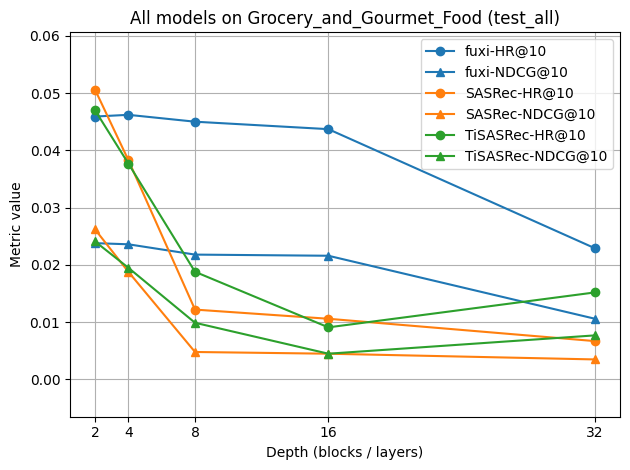

In [40]:
# ====== 3 个模型在 Grocery_and_Gourmet_Food 上的表现（6 条线） ======

# 对每个模型指定对应的深度列表
DEPTHS_MAP_GROCERY = {
    "fuxi":    [2, 4, 8, 16, 32],
    "SASRec":  [2, 4, 8, 16, 32],
    "TiSASRec":[2, 4, 8, 16, 32],
}

DATASET_TAG = "grocery"
EVAL_TYPE = "test_all"   # 如需全测试就改成 "test_all"

def plot_all_models_one_dataset(dataset_tag: str,
                                depths_map: dict,
                                eval_type: str = "test",
                                save: bool = True):
    """
    在同一张图中画出 3 个模型在某个数据集上的 HR@10 / NDCG@10 曲线。
    - 颜色区分模型
    - marker 区分指标：HR@10 用圆点 'o'，NDCG@10 用三角 '^'
    """
    # 模型顺序，决定图例顺序和颜色映射
    models = ["fuxi", "SASRec", "TiSASRec"]

    # 颜色区分模型
    color_map = {
        "fuxi": "C0",
        "SASRec": "C1",
        "TiSASRec": "C2",
    }

    # marker 区分指标
    marker_map = {
        "HR@10": "o",   # 圆点
        "NDCG@10": "^", # 三角
    }

    # 所有深度的并集，用于 x 轴刻度显示
    all_depths = sorted({d for depth_list in depths_map.values() for d in depth_list})

    # 收集所有曲线的值，用来设定 y 轴上下界
    all_values = []

    plt.figure()

    for model in models:
        if model not in depths_map:
            continue
        depths = depths_map[model]
        if not depths:
            continue

        depths_found, metrics_dict = load_metrics_over_depths(
            model=model,
            dataset_tag=dataset_tag,
            depths=depths,
            eval_type=eval_type,
        )

        if len(depths_found) == 0:
            print(f"[WARN] 模型 {model} 在数据集 {dataset_tag} 上没有读到任何深度的数据")
            continue

        # 按深度排序
        order = np.argsort(depths_found)
        x = depths_found[order]

        for metric_name in METRICS_ORDER:
            y = np.array(metrics_dict[metric_name])[order]
            all_values.append(y)

            plt.plot(
                x,
                y,
                marker=marker_map.get(metric_name, "o"),
                color=color_map.get(model, None),
                label=f"{model}-{metric_name}",
            )

    if not all_values:
        print("[ERROR] 没有任何可画的数据。")
        plt.close()
        return

    # 计算 y 轴范围
    all_values_arr = np.concatenate(all_values)
    all_values_arr = all_values_arr[~np.isnan(all_values_arr)]
    y_min = all_values_arr.min() - 0.01
    y_max = all_values_arr.max() + 0.01

    # x 轴刻度：所有用到的深度
    plt.xticks(all_depths)

    plt.xlabel("Depth (blocks / layers)")
    plt.ylabel("Metric value")

    pretty_dataset = {
        "grocery": "Grocery_and_Gourmet_Food",
        "movielens_1M": "MovieLens_1M",
    }.get(dataset_tag, dataset_tag)

    plt.title(f"All models on {pretty_dataset} ({eval_type})")
    plt.grid(True)
    plt.legend()
    plt.ylim(y_min, y_max)
    plt.tight_layout()

    if save:
        os.makedirs("figure", exist_ok=True)
        out_name = f"all_models_{dataset_tag}_{eval_type}.png"
        out_path = os.path.join("figure", out_name)
        plt.savefig(out_path)
        print(f"[INFO] 图像已保存到: {out_path}")

    plt.show()


# ==== 真正调用：Grocery_and_Gourmet_Food ====
plot_all_models_one_dataset(
    dataset_tag=DATASET_TAG,
    depths_map=DEPTHS_MAP_GROCERY,
    eval_type=EVAL_TYPE,
    save=True,
)


[DEBUG] 构造文件名: model=fuxi, dataset=movielens_1M, depth=2, eval=test_all
[DEBUG] 完整路径: logs_saved/fuxi_movielens_1M_depth_2_test_all.txt
[INFO] 读取文件: logs_saved/fuxi_movielens_1M_depth_2_test_all.txt
[INFO] 解析到指标: {'HR@5': 0.1821, 'NDCG@5': 0.121, 'HR@10': 0.2714, 'NDCG@10': 0.15, 'HR@20': 0.3839, 'NDCG@20': 0.1784, 'HR@50': 0.5573, 'NDCG@50': 0.2129}
[DEBUG] 构造文件名: model=fuxi, dataset=movielens_1M, depth=4, eval=test_all
[DEBUG] 完整路径: logs_saved/fuxi_movielens_1M_depth_4_test_all.txt
[INFO] 读取文件: logs_saved/fuxi_movielens_1M_depth_4_test_all.txt
[INFO] 解析到指标: {'HR@5': 0.1684, 'NDCG@5': 0.1111, 'HR@10': 0.2604, 'NDCG@10': 0.1407, 'HR@20': 0.3811, 'NDCG@20': 0.1711, 'HR@50': 0.5576, 'NDCG@50': 0.2062}
[DEBUG] 构造文件名: model=fuxi, dataset=movielens_1M, depth=8, eval=test_all
[DEBUG] 完整路径: logs_saved/fuxi_movielens_1M_depth_8_test_all.txt
[INFO] 读取文件: logs_saved/fuxi_movielens_1M_depth_8_test_all.txt
[INFO] 解析到指标: {'HR@5': 0.1844, 'NDCG@5': 0.1196, 'HR@10': 0.274, 'NDCG@10': 0.1483, 'HR@20':

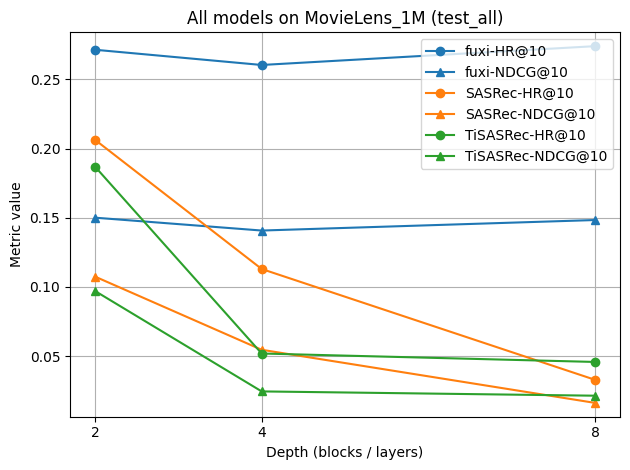

In [41]:
# ====== 3 个模型在 MovieLens_1M 上的表现（6 条线） ======

DEPTHS_MAP_MOVIELENS = {
    "fuxi":    [2, 4, 8],
    "SASRec":  [2, 4, 8],
    "TiSASRec":[2, 4, 8],
}

DATASET_TAG = "movielens_1M"
EVAL_TYPE = "test_all"   # 或者 "test_all"

plot_all_models_one_dataset(
    dataset_tag=DATASET_TAG,
    depths_map=DEPTHS_MAP_MOVIELENS,
    eval_type=EVAL_TYPE,
    save=True,
)
